In [16]:
import re
import typing as t
from collections import defaultdict
from pathlib import Path
import copy

import nltk
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import wordnet, stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [17]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [18]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\super\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [19]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [20]:
DATA_DIR = Path("data/")

In [21]:
def torch_train_test_split(dataset: t.Union[Dataset, t.Sized], test_size: float) -> t.Tuple[Subset, Subset]:
    test_size = round(test_size * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset


def unique_stat(df: pd.DataFrame) -> pd.Series:
    uniq_stat = df.nunique()
    return uniq_stat[(uniq_stat == 1) | (uniq_stat == len(df))]


def na_stat(df: pd.DataFrame) -> pd.Series:
    stat = df.isna().sum()
    return stat[stat > 0]


def duplicates_stat(df: pd.DataFrame) -> pd.Series:
    return df[df.duplicated()].value_counts()


def get_categorical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(object).columns


def get_numerical_columns(df: pd.DataFrame) -> pd.Index:
    return df.select_dtypes(np.number).columns


def count_categories(df: pd.DataFrame) -> pd.Series:
    return df[get_categorical_columns(df)].nunique()

# Regression

## concrete.csv

In [22]:
concrete_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/concrete.csv")
print(concrete_df.shape)
concrete_df.head()

(1030, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [23]:
na_stat(concrete_df)

Series([], dtype: int64)

In [24]:
duplicates_stat(concrete_df)

Cement (component 1)(kg in a m^3 mixture)  Blast Furnace Slag (component 2)(kg in a m^3 mixture)  Fly Ash (component 3)(kg in a m^3 mixture)  Water  (component 4)(kg in a m^3 mixture)  Superplasticizer (component 5)(kg in a m^3 mixture)  Coarse Aggregate  (component 6)(kg in a m^3 mixture)  Fine Aggregate (component 7)(kg in a m^3 mixture)  Age (day)  strength
362.6                                      189.0                                                  0.0                                         164.9                                      11.6                                                 944.7                                                 755.8                                              3          35.30       3
                                                                                                                                                                                                                                                                             

In [25]:
concrete_df = concrete_df.drop_duplicates()
duplicates_stat(concrete_df)

Series([], dtype: int64)

In [26]:
print(concrete_df.shape)
concrete_df.head()

(1005, 9)


,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [27]:
class ConcreteDataset(Dataset):
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, scaler: StandardScaler = None):
        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "strength"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        self.data = torch.tensor(scale(data), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [28]:
concrete_train_df, concrete_test_df = train_test_split(concrete_df, test_size=0.2, random_state=0)

concrete_train_dataset = ConcreteDataset(concrete_train_df)
concrete_test_dataset = ConcreteDataset(concrete_test_df, scaler=concrete_train_dataset.scaler)
len(concrete_train_dataset), len(concrete_test_dataset), concrete_train_dataset.num_features

(804, 201, 8)

## gold.csv

## house.csv

In [31]:
house_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/house.csv")
print(house_df.shape)
house_df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [32]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          1460 non-null   object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [33]:
# https://www.kaggle.com/code/emmanueldjegou/house-prices-advanced-regression-techniques/notebook
house_df = house_df[[
    "SalePrice",  # target
    "OverallQual",
    "GrLivArea",
    "TotalBsmtSF",
    "GarageCars",
    "BsmtFinSF1",
    "Fireplaces",
    "Foundation",
    "BsmtQual",
    "KitchenQual",
    "WoodDeckSF",
    "LotShape",
    "Neighborhood",
    "HouseStyle",
    "SaleCondition",
]]

In [34]:
na_stat(house_df)

Series([], dtype: int64)

In [35]:
duplicates_stat(house_df)

SalePrice  OverallQual  GrLivArea  TotalBsmtSF  GarageCars  BsmtFinSF1  Fireplaces  Foundation  BsmtQual  KitchenQual  WoodDeckSF  LotShape  Neighborhood  HouseStyle  SaleCondition
151000     7            1200       600          2           0           0           PConc       Gd        Gd           0           Reg       Somerst       2Story      Normal           1
dtype: int64

In [36]:
house_df = house_df.drop_duplicates()
duplicates_stat(house_df)

Series([], dtype: int64)

In [37]:
count_categories(house_df)

Foundation        6
BsmtQual          5
KitchenQual       4
LotShape          4
Neighborhood     25
HouseStyle        8
SaleCondition     6
dtype: int64

In [38]:
print(house_df.shape)
house_df.head()

(1459, 15)


,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,BsmtFinSF1,Fireplaces,Foundation,BsmtQual,KitchenQual,WoodDeckSF,LotShape,Neighborhood,HouseStyle,SaleCondition
0,208500,7,1710,856,2,706,0,PConc,Gd,Gd,0,Reg,CollgCr,2Story,Normal
1,181500,6,1262,1262,2,978,1,CBlock,Gd,TA,298,Reg,Veenker,1Story,Normal
2,223500,7,1786,920,2,486,1,PConc,Gd,Gd,0,IR1,CollgCr,2Story,Normal
3,140000,7,1717,756,3,216,1,BrkTil,TA,Gd,0,IR1,Crawfor,2Story,Abnorml
4,250000,8,2198,1145,3,655,1,PConc,Gd,Gd,192,IR1,NoRidge,2Story,Normal


In [39]:
class HouseDataset(Dataset):
    encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "SalePrice"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [40]:
house_train_df, house_test_df = train_test_split(house_df, test_size=0.2, random_state=0)

house_train_dataset = HouseDataset(house_train_df)
house_test_dataset = HouseDataset(
    house_test_df,
    encoder=house_train_dataset.encoder,
    scaler=house_train_dataset.scaler,
)
len(house_train_dataset), len(house_test_dataset), house_train_dataset.num_features

(1167, 292, 14)

## insurance.csv

In [43]:
insurance_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/insurance.csv")
print(insurance_df.shape)
insurance_df.head()

(1338, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [44]:
na_stat(insurance_df)

Series([], dtype: int64)

In [45]:
duplicates_stat(insurance_df)

age  sex   bmi    children  smoker  region     charges  
19   male  30.59  0         no      northwest  1639.5631    1
dtype: int64

In [46]:
insurance_df = insurance_df.drop_duplicates()
duplicates_stat(insurance_df)

Series([], dtype: int64)

In [47]:
count_categories(insurance_df)

sex       2
smoker    2
region    4
dtype: int64

In [48]:
print(insurance_df.shape)
insurance_df.head()

(1337, 7)


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [49]:
class InsuranceDataset(Dataset):
    encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "charges"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [50]:
insurance_train_df, insurance_test_df = train_test_split(insurance_df, test_size=0.2, random_state=0)

insurance_train_dataset = InsuranceDataset(insurance_train_df)
insurance_test_dataset = InsuranceDataset(
    insurance_test_df,
    encoder=insurance_train_dataset.encoder,
    scaler=insurance_train_dataset.scaler,
)
len(insurance_train_dataset), len(insurance_test_dataset), insurance_train_dataset.num_features

(1069, 268, 6)

## vehicle.csv

In [53]:
vehicle_df: pd.DataFrame = pd.read_csv(DATA_DIR / "regression/vehicle.csv")
print(vehicle_df.shape)
vehicle_df.head()

(8128, 13)


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


In [54]:
vehicle_df = vehicle_df.drop(columns=["name", "mileage", "torque"])
vehicle_df["max_power"] = vehicle_df["max_power"].str.replace(" bhp", "").replace("", np.nan).astype(float)

In [55]:
na_stat(vehicle_df)

engine       221
max_power    216
seats        221
dtype: int64

In [56]:
vehicle_df = vehicle_df.dropna()
na_stat(vehicle_df)

Series([], dtype: int64)

In [57]:
duplicates_stat(vehicle_df)

year  selling_price  km_driven  fuel    seller_type       transmission  owner         engine   max_power  seats
2017  3200000        45000      Diesel  Dealer            Automatic     First Owner   1999 CC  177.00     5.0      33
2019  5150000        20000      Petrol  Dealer            Automatic     First Owner   2487 CC  214.56     5.0      33
2016  2000000        68089      Petrol  Trustmark Dealer  Automatic     First Owner   2494 CC  157.70     5.0      31
      550000         56494      Petrol  Trustmark Dealer  Manual        First Owner   1199 CC  88.70      5.0      31
2013  750000         79328      Diesel  Trustmark Dealer  Manual        Second Owner  2494 CC  100.60     7.0      30
                                                                                                                   ..
2015  245000         40000      Petrol  Individual        Manual        First Owner   796 CC   47.30      5.0       1
      250000         80000      Diesel  Individual        Manu

In [58]:
vehicle_df = vehicle_df.drop_duplicates()
duplicates_stat(vehicle_df)

Series([], dtype: int64)

In [59]:
count_categories(vehicle_df)

fuel              4
seller_type       3
transmission      2
owner             5
engine          121
dtype: int64

In [60]:
print(vehicle_df.shape)
vehicle_df.head()

(6690, 10)


,year,selling_price,km_driven,fuel,seller_type,transmission,owner,engine,max_power,seats
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,1248 CC,74.00,5.0
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,1498 CC,103.52,5.0
2,2006,158000,140000,Petrol,Individual,Manual,Third Owner,1497 CC,78.00,5.0
3,2010,225000,127000,Diesel,Individual,Manual,First Owner,1396 CC,90.00,5.0
4,2007,130000,120000,Petrol,Individual,Manual,First Owner,1298 CC,88.20,5.0


In [61]:
class VehicleDataset(Dataset):
    encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode = self.encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "selling_price"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.float).unsqueeze(1)
        self.num_features = self.data.size(1)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [62]:
vehicle_train_df, vehicle_test_df = train_test_split(vehicle_df, test_size=0.2, random_state=0)

vehicle_train_dataset = VehicleDataset(vehicle_train_df)
vehicle_test_dataset = VehicleDataset(
    vehicle_test_df,
    encoder=vehicle_train_dataset.encoder,
    scaler=vehicle_train_dataset.scaler,
)
len(vehicle_train_dataset), len(vehicle_test_dataset), vehicle_train_dataset.num_features

(5352, 1338, 9)

# Feature classification

## bank.csv

## credit.csv

In [65]:
credit_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/credit.csv")
print(credit_df.shape)
credit_df.head()

(24000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


In [66]:
unique_stat(credit_df)

Series([], dtype: int64)

In [67]:
na_stat(credit_df)

Series([], dtype: int64)

In [68]:
duplicates_stat(credit_df)

LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  default
20000      1    2          2         24    2      2      4      4      4      4     1650.0     1650.0     1650.0     1650.0     1650.0     1650.0     0.0       0.0       0.0       0.0       0.0       0.0       1          1
50000      1    2          2         26    1     -2     -2     -2     -2     -2     0.0        0.0        0.0        0.0        0.0        0.0        0.0       0.0       0.0       0.0       0.0       0.0       0          1
360000     2    1          2         29    1     -2     -2     -2     -2     -2     0.0        0.0        0.0        0.0        0.0        0.0        0.0       0.0       0.0       0.0       0.0       0.0       0          1
                           1         41   -2     -2     -2     -2     -2     -2     0.0        0.0        0.0    

In [69]:
credit_df = credit_df.drop_duplicates()
duplicates_stat(credit_df)

Series([], dtype: int64)

In [70]:
print(credit_df.shape)
credit_df.head()

(23976, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,90000,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
2,50000,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
3,50000,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
4,50000,1,1,2,37,0,0,0,0,0,...,19394.0,19619.0,20024.0,2500.0,1815.0,657.0,1000.0,1000.0,800.0,0


0    18675
1     5301
Name: default, dtype: int64


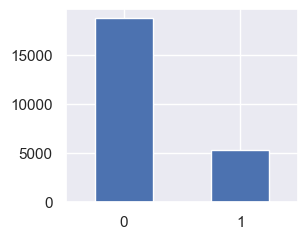

In [71]:
vc = credit_df["default"].value_counts()
print(vc)
credit_df["default"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [72]:
class CreditDataset(Dataset):
    scaler: StandardScaler
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, scaler: StandardScaler = None):
        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "default"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        self.data = torch.tensor(scale(data), dtype=torch.float)
        self.num_features = self.data.size(1)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.long)
        self.classes = [str(cls) for cls in targets.unique()]

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [73]:
credit_train_df, credit_test_df = train_test_split(credit_df, test_size=0.2, random_state=0)

credit_train_dataset = CreditDataset(credit_train_df)
credit_test_dataset = CreditDataset(credit_test_df, scaler=credit_train_dataset.scaler)
len(credit_train_dataset), len(credit_test_dataset), credit_train_dataset.num_features, credit_train_dataset.classes

(19180, 4796, 23, ['1', '0'])

## employee.csv

In [76]:
employee_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/employee.csv")
print(employee_df.shape)
employee_df.head()

(14999, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


In [77]:
unique_stat(employee_df)

Series([], dtype: int64)

In [78]:
na_stat(employee_df)

Series([], dtype: int64)

In [79]:
duplicates_stat(employee_df)

satisfaction_level  last_evaluation  number_project  average_montly_hours  time_spend_company  Work_accident  promotion_last_5years  department  salary  left
0.46                0.57             2               139                   3                   0              0                      sales       low     1       5
0.37                0.51             2               127                   3                   0              0                      sales       medium  1       3
0.42                0.53             2               142                   3                   0              0                      sales       low     1       3
0.41                0.46             2               128                   3                   0              0                      accounting  low     1       3
0.10                0.85             6               266                   4                   0              0                      sales       low     1       3
                           

In [80]:
employee_df = employee_df.drop_duplicates()
duplicates_stat(employee_df)

Series([], dtype: int64)

In [81]:
count_categories(employee_df)

department    10
salary         3
dtype: int64

In [82]:
print(employee_df.shape)
employee_df.head()

(11991, 10)


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


0    10000
1     1991
Name: left, dtype: int64


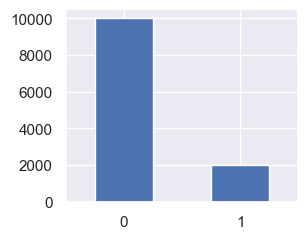

In [83]:
vc = employee_df["left"].value_counts()
print(vc)
employee_df["left"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [84]:
class EmployeeDataset(Dataset):
    feature_encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, feature_encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if feature_encoder:
            self.feature_encoder = feature_encoder
            encode_features = self.feature_encoder.transform
        else:
            self.feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode_features = self.feature_encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "left"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode_features(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.num_features = self.data.size(1)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.long)
        self.classes = [str(cls) for cls in targets.unique()]

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [85]:
employee_train_df, employee_test_df = train_test_split(employee_df, test_size=0.2, random_state=0)

employee_train_dataset = EmployeeDataset(employee_train_df)
employee_test_dataset = EmployeeDataset(
    employee_test_df,
    feature_encoder=employee_train_dataset.feature_encoder,
    scaler=employee_train_dataset.scaler,
)
len(employee_train_dataset), len(employee_test_dataset), employee_train_dataset.num_features, employee_train_dataset.classes

(9592, 2399, 9, ['0', '1'])

## hr_analytics.csv

In [88]:
hr_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/hr_analytics.csv")
print(hr_df.shape)
hr_df.head()

(4410, 24)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,...,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,1,Female,...,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,2,Female,...,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,3,Male,...,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,4,Male,...,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,5,Male,...,4.0,Y,12,8,2,9.0,2,6,0,4


In [89]:
uniq_stat = unique_stat(hr_df)
uniq_stat

EmployeeCount       1
EmployeeID       4410
Over18              1
StandardHours       1
dtype: int64

In [90]:
hr_df = hr_df.drop(columns=uniq_stat.index)
unique_stat(hr_df)

Series([], dtype: int64)

In [91]:
na_stat(hr_df)

NumCompaniesWorked    19
TotalWorkingYears      9
dtype: int64

In [92]:
hr_df = hr_df.dropna()
na_stat(hr_df)

Series([], dtype: int64)

In [93]:
duplicates_stat(hr_df)

Age  Attrition  BusinessTravel     Department              DistanceFromHome  Education  EducationField    Gender  JobLevel  JobRole                    MaritalStatus  MonthlyIncome  NumCompaniesWorked  PercentSalaryHike  StockOptionLevel  TotalWorkingYears  TrainingTimesLastYear  YearsAtCompany  YearsSinceLastPromotion  YearsWithCurrManager
18   No         Non-Travel         Research & Development  1                 4          Medical           Male    2         Sales Executive            Single         27200          1.0                 22                 1                 0.0                2                      0               0                        0                       2
40   No         Travel_Rarely      Research & Development  17                4          Life Sciences     Male    1         Manager                    Married        35780          2.0                 14                 1                 20.0               2                      5               0              

In [94]:
hr_df = hr_df.drop_duplicates()
duplicates_stat(hr_df)

Series([], dtype: int64)

In [95]:
count_categories(hr_df)

Attrition         2
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
dtype: int64

In [96]:
print(hr_df.shape)
hr_df.head()

(1470, 20)


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,Female,1,Healthcare Representative,Married,131160,1.0,11,0,1.0,6,1,0,0
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,Female,1,Research Scientist,Single,41890,0.0,23,1,6.0,3,5,1,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,Male,4,Sales Executive,Married,193280,1.0,15,3,5.0,2,5,0,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,Male,3,Human Resources,Married,83210,3.0,11,3,13.0,5,8,7,5
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,Male,1,Sales Executive,Single,23420,4.0,12,2,9.0,2,6,0,4


No     1233
Yes     237
Name: Attrition, dtype: int64


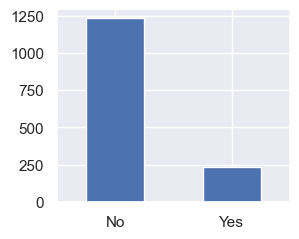

In [97]:
vc = hr_df["Attrition"].value_counts()
print(vc)
hr_df["Attrition"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [98]:
class HRDataset(Dataset):
    feature_encoder: OrdinalEncoder
    scaler: StandardScaler
    target_encoder: LabelEncoder
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(
            self,
            df: pd.DataFrame,
            feature_encoder: OrdinalEncoder = None,
            scaler: StandardScaler = None,
            target_encoder: LabelEncoder = None,
    ):
        if feature_encoder:
            self.feature_encoder = feature_encoder
            encode_features = self.feature_encoder.transform
        else:
            self.feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode_features = self.feature_encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        if target_encoder:
            self.target_encoder = target_encoder
            encode_targets = self.target_encoder.transform
        else:
            self.target_encoder = LabelEncoder()
            encode_targets = self.target_encoder.fit_transform

        target_col = "Attrition"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode_features(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.num_features = self.data.size(1)
        targets = encode_targets(targets)
        self.classes = self.target_encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [99]:
hr_train_df, hr_test_df = train_test_split(hr_df, test_size=0.2, random_state=0)

hr_train_dataset = HRDataset(hr_train_df)
hr_test_dataset = HRDataset(
    hr_test_df,
    feature_encoder=hr_train_dataset.feature_encoder,
    scaler=hr_train_dataset.scaler,
    target_encoder=hr_train_dataset.target_encoder,
)
len(hr_train_dataset), len(hr_test_dataset), hr_train_dataset.num_features, hr_train_dataset.classes

(1176, 294, 19, ['No', 'Yes'])

In [100]:
hr_train_dataloader = DataLoader(hr_train_dataset, batch_size=4, shuffle=True)
hr_test_dataloader = DataLoader(hr_test_dataset, batch_size=len(hr_test_dataset))

In [101]:
next(iter(hr_train_dataloader))

[tensor([[-0.9623,  2.0000,  1.0000, -0.2762,  0.1056,  3.0000,  1.0000,  0.8497,
           0.0000,  0.0000,  1.1812, -0.6787, -0.6163, -0.9230, -0.1443, -0.6519,
           0.5072, -0.3612,  1.1164],
         [-0.8538,  2.0000,  1.0000,  2.4447,  0.1056,  3.0000,  0.0000, -0.9475,
           6.0000,  1.0000, -0.8980, -0.6787, -0.6163,  0.2724, -0.5385, -2.2022,
           0.0093, -0.6756,  0.8321],
         [-0.9623,  2.0000,  2.0000, -0.1525,  1.0990,  2.0000,  1.0000, -0.9475,
           2.0000,  0.0000,  2.1184, -0.6787,  0.1965, -0.9230, -1.3268,  0.1233,
          -0.9864, -0.6756, -1.1585],
         [ 1.1006,  0.0000,  1.0000,  1.4553, -0.8878,  3.0000,  1.0000, -0.9475,
           7.0000,  1.0000, -0.3956, -1.0810, -1.1582,  0.2724,  0.3812, -0.6519,
           1.0050,  0.8964,  2.2539]]),
 tensor([0, 1, 0, 0])]

## income.csv

In [102]:
income_df: pd.DataFrame = pd.read_csv(DATA_DIR / "classification/income.csv")
print(income_df.shape)
income_df.head()

(32561, 14)


,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


In [103]:
income_df = income_df.drop(columns=["education-num"])

In [104]:
unique_stat(income_df)

Series([], dtype: int64)

In [105]:
na_stat(income_df)

workclass         1836
occupation        1843
native-country     583
dtype: int64

In [106]:
income_df = income_df.dropna()
na_stat(income_df)

Series([], dtype: int64)

In [107]:
duplicates_stat(income_df)

age  workclass  education     marital-status      occupation         relationship   race                sex     capital-gain  capital-loss  hours-per-week  native-country  income >50K
33   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              15
35   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              14
51   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              13
39   Private    HS-grad       Married-civ-spouse  Craft-repair       Husband        White               Male    0             0             40              United-States   0              13
37   Private    HS-grad       Married-civ-spouse  Craft-

In [108]:
income_df = income_df.drop_duplicates()
duplicates_stat(income_df)

Series([], dtype: int64)

In [109]:
count_categories(income_df)

workclass          7
education         16
marital-status     7
occupation        14
relationship       6
race               5
sex                2
native-country    41
dtype: int64

In [110]:
print(income_df.shape)
income_df.head()

(26904, 13)


,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income >50K
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,0
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,0
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,0
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,0
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,0


0    20024
1     6880
Name: income >50K, dtype: int64


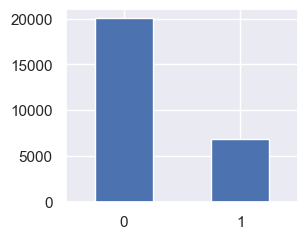

In [111]:
vc = income_df["income >50K"].value_counts()
print(vc)
income_df["income >50K"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [112]:
class IncomeDataset(Dataset):
    feature_encoder: OrdinalEncoder
    scaler: StandardScaler
    num_features: int
    classes: t.List[str]

    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, feature_encoder: OrdinalEncoder = None, scaler: StandardScaler = None):
        if feature_encoder:
            self.feature_encoder = feature_encoder
            encode_features = self.feature_encoder.transform
        else:
            self.feature_encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
            encode_features = self.feature_encoder.fit_transform

        if scaler:
            self.scaler = scaler
            scale = self.scaler.transform
        else:
            self.scaler = StandardScaler()
            scale = self.scaler.fit_transform

        target_col = "income >50K"
        data, targets = df.drop(columns=[target_col]), df[target_col]

        encode_cols, scale_cols = get_categorical_columns(data), get_numerical_columns(data)
        data[encode_cols] = encode_features(data[encode_cols])
        data[scale_cols] = scale(data[scale_cols])

        self.data = torch.tensor(data.to_numpy(), dtype=torch.float)
        self.num_features = self.data.size(1)
        self.targets = torch.tensor(targets.to_numpy(), dtype=torch.long)
        self.classes = [str(cls) for cls in targets.unique()]

    def __len__(self):
        return self.targets.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [113]:
income_train_df, income_test_df = train_test_split(income_df, test_size=0.2, random_state=0)

income_train_dataset = IncomeDataset(income_train_df)
income_test_dataset = IncomeDataset(
    income_test_df,
    feature_encoder=income_train_dataset.feature_encoder,
    scaler=income_train_dataset.scaler,
)
len(income_train_dataset), len(income_test_dataset), income_train_dataset.num_features, income_train_dataset.classes

(21523, 5381, 12, ['1', '0'])

In [114]:
income_train_dataloader = DataLoader(income_train_dataset, batch_size=4, shuffle=True)
income_test_dataloader = DataLoader(income_test_dataset, batch_size=len(income_test_dataset))

In [115]:
next(iter(income_train_dataloader))

[tensor([[-0.8372,  3.0000, 11.0000,  4.0000,  0.0000,  3.0000,  4.0000,  0.0000,
          -0.1555, -0.2310, -0.4982, 38.0000],
         [ 0.5284,  2.0000, 15.0000,  2.0000,  3.0000,  0.0000,  4.0000,  1.0000,
          -0.1555, -0.2310, -0.0930, 38.0000],
         [-1.5960,  2.0000,  6.0000,  4.0000, 11.0000,  3.0000,  4.0000,  0.0000,
          -0.1555, -0.2310,  0.0691, 38.0000],
         [ 0.0732,  2.0000, 15.0000,  2.0000, 13.0000,  0.0000,  4.0000,  1.0000,
          -0.1555, -0.2310,  0.7174, 38.0000]]),
 tensor([0, 1, 0, 0])]

# Image classification

In [116]:
def show_sample_images(dataset: ImageFolder, cols: int = 3, rows: int = 3):
    _, axes = plt.subplots(cols, rows, figsize=(6, 6))
    for i, ax in zip(torch.randperm(len(dataset)), axes.flatten()):
        img, target = dataset[i]
        ax.axis("off")
        ax.set_title(dataset.classes[target])
        ax.imshow(img)

## chars

marvel       193
star-wars    139
dtype: int64


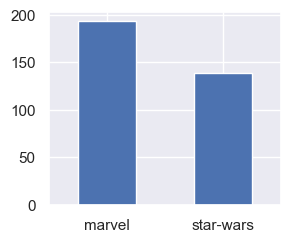

In [117]:
base_transform = transforms.Compose([transforms.Resize(size=(96, 96))])
chars_dataset = ImageFolder(DATA_DIR / "images/chars", transform=base_transform)

vc = pd.value_counts(chars_dataset.targets)
vc.index = [chars_dataset.classes[i] for i in vc.index]
print(vc)
vc.plot.bar(rot=0, figsize=(3, 2.5));

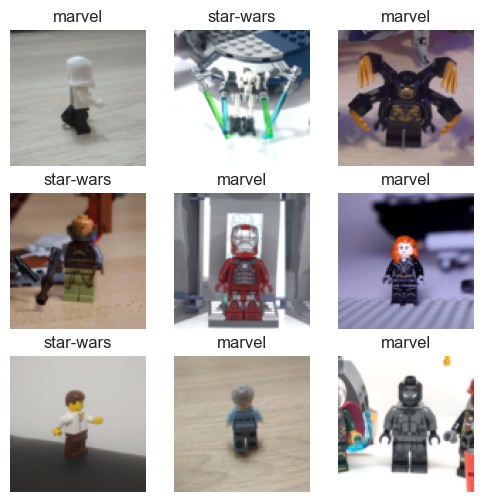

In [118]:
torch.manual_seed(0)
show_sample_images(chars_dataset)

In [119]:
torch.manual_seed(0)

train_transform = transforms.Compose([
    *base_transform.transforms,
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
test_transform = transforms.Compose([
    *base_transform.transforms,
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

chars_train_dataset, chars_test_dataset = torch_train_test_split(chars_dataset, test_size=0.2)
# кажется, это называется лень
chars_train_dataset.dataset = copy.deepcopy(chars_train_dataset.dataset)
chars_train_dataset.dataset.transform = train_transform
chars_test_dataset.dataset.transform = test_transform

len(chars_train_dataset), len(chars_test_dataset)

(266, 66)

## eng_handwritten

## fruits

## masks

## sign_language

# Text classification

In [120]:
def get_pos(word: str) -> str:
    tag = nltk.pos_tag([word])[0][1]
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


_wordnet_lemmatizer = nltk.WordNetLemmatizer()


def wordnet_lemmatizer(token: str) -> str:
    return _wordnet_lemmatizer.lemmatize(token, pos=get_pos(token))


_snowball_stemmer = nltk.SnowballStemmer(language="english")


def snowball_stemmer(token: str) -> str:
    return _snowball_stemmer.stem(token)


RE_URL = re.compile(r"\w+://\S+", flags=re.MULTILINE)
RE_HASHTAG = re.compile(r"#\S+", flags=re.MULTILINE)
RE_TW_USERNAME = re.compile(r"@\S+", flags=re.MULTILINE)
RE_NOT_ASCII_LOW = re.compile(r"[^a-z]", flags=re.MULTILINE)
STOPWORDS = set(stopwords.words("english"))


def preprocess_text(
        text: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    text = text.lower()
    for pat in [RE_URL, RE_NOT_ASCII_LOW]:
        text = pat.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)


def preprocess_tweet(
        text: str,
        lemmatizer_or_stemmer: t.Callable[[str], str] = None,
        min_word_len: int = 0,
) -> str:
    text = text.lower()
    for pat in [RE_URL, RE_HASHTAG, RE_TW_USERNAME, RE_NOT_ASCII_LOW]:
        text = pat.sub(" ", text)

    words = []
    for word in nltk.word_tokenize(text):
        if word not in STOPWORDS and len(word) >= min_word_len:
            if not lemmatizer_or_stemmer:
                words.append(word)
                continue
            word = lemmatizer_or_stemmer(word)
            if word not in STOPWORDS and len(word) >= min_word_len:
                words.append(word)

    return " ".join(words)


class WordVocab:
    pad = "<PAD>"
    unknown = "<UNK>"

    def __init__(self, texts: t.List[str]):
        uniques = set()
        max_len = 0
        for text in texts:
            words = nltk.word_tokenize(text)
            uniques.update(words)
            max_len = max(len(words), max_len)

        self.alphabet = [self.pad, self.unknown, *uniques]
        self.max_len = max_len

        w2i = {w: i for i, w in enumerate(self.alphabet)}
        unknown_idx = w2i[self.unknown]
        self.w2i = defaultdict(lambda: unknown_idx, w2i)

    def __len__(self):
        return len(self.alphabet)

    def encode(self, text: str) -> torch.Tensor:
        indices = [self.w2i[w] for w in nltk.word_tokenize(text)]
        indices += [self.w2i[self.pad]] * (self.max_len - len(indices))
        return torch.tensor(indices, dtype=torch.long)

    def decode(self, indices: torch.Tensor) -> str:
        pad_indices = torch.nonzero(indices == self.w2i[self.pad], as_tuple=True)[0]  # noqa
        if len(pad_indices):
            indices = indices[:pad_indices[0]]
        return " ".join(self.alphabet[i] for i in indices)

## activities.csv

In [121]:
class ActivitiesDataset(Dataset):
    DATA_COL = "Text"
    TARGET_COL = "Review-Activity"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = self.encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_text(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

ACTIVITY    5726
REVIEW      4274
Name: Review-Activity, dtype: int64


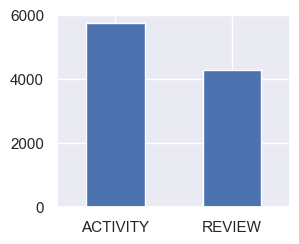

In [122]:
activities_df = pd.read_csv(DATA_DIR / "nlp/activities.csv")
vc = activities_df["Review-Activity"].value_counts()
print(vc)
activities_df["Review-Activity"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [123]:
activities_train_df, activities_test_df = train_test_split(activities_df, test_size=0.2, random_state=0)

activities_train_dataset = ActivitiesDataset(activities_train_df)
activities_test_dataset = ActivitiesDataset(
    activities_test_df,
    vocab=activities_train_dataset.vocab,
    encoder=activities_train_dataset.encoder,
)
print(len(activities_train_dataset.vocab), activities_train_dataset.vocab.max_len)
len(activities_train_dataset), len(activities_test_dataset), activities_train_dataset.classes

100%|██████████| 2000/2000 [00:24<00:00, 82.29it/s]


15364 87


(8000, 2000, ['ACTIVITY', 'REVIEW'])

In [124]:
activities_train_dataloader = DataLoader(activities_train_dataset, batch_size=2, shuffle=True)
activities_test_dataloader = DataLoader(activities_test_dataset, batch_size=len(activities_test_dataset))

In [125]:
next(iter(activities_train_dataloader))

[tensor([[11546,  6488,  9987,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0],
         [13443,  9017, 12102,  1476,  8783,  1476, 12606, 13718, 14237,  4979,
           7922,  3891,  5548,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,  

## corona.csv

In [126]:
class CoronaDataset(Dataset):
    DATA_COL = "OriginalTweet"
    TARGET_COL = "Sentiment"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = self.encoder.classes_.tolist()
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_tweet(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

Positive              2783
Negative              2427
Neutral               1864
Extremely Positive    1589
Extremely Negative    1337
Name: Sentiment, dtype: int64


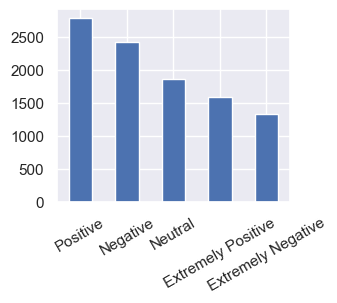

In [127]:
corona_df = pd.read_csv(DATA_DIR / "nlp/corona.csv")
vc = corona_df["Sentiment"].value_counts()
print(vc)
corona_df["Sentiment"].value_counts().plot.bar(rot=30, figsize=(3, 2.5));

In [128]:
corona_train_df, corona_test_df = train_test_split(corona_df, test_size=0.2, random_state=0)

corona_train_dataset = CoronaDataset(corona_train_df)
corona_test_dataset = CoronaDataset(
    corona_test_df,
    vocab=corona_train_dataset.vocab,
    encoder=corona_train_dataset.encoder,
)
print(len(corona_train_dataset.vocab), corona_train_dataset.vocab.max_len)
len(corona_train_dataset), len(corona_test_dataset), corona_train_dataset.classes

100%|██████████| 2000/2000 [00:16<00:00, 119.09it/s]


11028 36


(8000,
 2000,
 ['Extremely Negative',
  'Extremely Positive',
  'Negative',
  'Neutral',
  'Positive'])

In [129]:
corona_train_dataloader = DataLoader(corona_train_dataset, batch_size=2, shuffle=True)
corona_test_dataloader = DataLoader(corona_test_dataset, batch_size=len(corona_test_dataset))

In [130]:
next(iter(corona_train_dataloader))

[tensor([[ 7037,  2843, 10746,  6743,  3772,  2033,  7067,  3672, 10563,  9866,
          10884,  4745,    68,  3772,  7910,  2137,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0],
         [ 6885,  2190,  8296,  2135,  1699, 10450,    22,  1607,  7521,  9098,
            875,  5396,  4191,  8416,  2022,  4581,  2155,  9046,  7910,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0]]),
 tensor([4, 4])]

## news.csv

In [131]:
class NewsDataset(Dataset):
    DATA_COL = "Description"  # или Title
    TARGET_COL = "Class Index"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = [str(cls) for cls in self.encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_text(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

1    2575
4    2489
3    2475
2    2461
Name: Class Index, dtype: int64


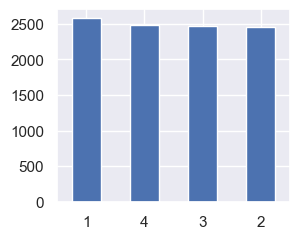

In [132]:
news_df = pd.read_csv(DATA_DIR / "nlp/news.csv")
vc = news_df["Class Index"].value_counts()
print(vc)
news_df["Class Index"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [133]:
news_train_df, news_test_df = train_test_split(news_df, test_size=0.2, random_state=0)

news_train_dataset = NewsDataset(news_train_df)
news_test_dataset = NewsDataset(
    news_test_df,
    vocab=news_train_dataset.vocab,
    encoder=news_train_dataset.encoder,
)
print(len(news_train_dataset.vocab), news_train_dataset.vocab.max_len)
len(news_train_dataset), len(news_test_dataset), news_train_dataset.classes

100%|██████████| 2000/2000 [00:20<00:00, 96.24it/s] 


15247 68


(8000, 2000, ['1', '2', '3', '4'])

In [134]:
news_train_dataloader = DataLoader(news_train_dataset, batch_size=2, shuffle=True)
news_test_dataloader = DataLoader(news_test_dataset, batch_size=len(news_test_dataset))

In [135]:
next(iter(news_train_dataloader))

[tensor([[ 6056,    44,  3411, 14770,  6869,  6171,  2186, 14530,  5670,  7284,
           6869,  9783, 10357,  7554, 11477,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0],
         [ 1382,  1724,  6869,  1523,  6780,   698,  1188,  7862,  7766,  5500,
          12272,  7230,  5500, 13634,  7993, 12272, 11869, 14309, 14641, 12272,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,  

## tweet_cat.csv

In [136]:
class TweetCatDataset(Dataset):
    DATA_COL = "text"
    TARGET_COL = "type"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = [str(cls) for cls in self.encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_tweet(text, lemmatizer_or_stemmer=wordnet_lemmatizer, min_word_len=3)

politics         345
medical          299
entertainment    260
sports           258
Name: type, dtype: int64


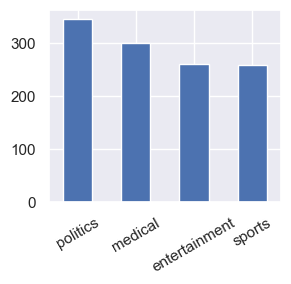

In [137]:
tweet_cat_df = pd.read_csv(DATA_DIR / "nlp/tweet_cat.csv")
vc = tweet_cat_df["type"].value_counts()
print(vc)
tweet_cat_df["type"].value_counts().plot.bar(rot=30, figsize=(3, 2.5));

In [138]:
tweet_cat_train_df, tweet_cat_test_df = train_test_split(tweet_cat_df, test_size=0.2, random_state=1)

tweet_cat_train_dataset = TweetCatDataset(tweet_cat_train_df)
tweet_cat_test_dataset = TweetCatDataset(
    tweet_cat_test_df,
    vocab=tweet_cat_train_dataset.vocab,
    encoder=tweet_cat_train_dataset.encoder,
)
print(len(tweet_cat_train_dataset.vocab), tweet_cat_train_dataset.vocab.max_len)
len(tweet_cat_train_dataset), len(tweet_cat_test_dataset), tweet_cat_train_dataset.classes

 86%|████████▌ | 200/233 [00:01<00:00, 132.45it/s]


3367 17


(929, 233, ['entertainment', 'medical', 'politics', 'sports'])

## tweets_disaster.csv

In [139]:
class TweetsDisasterDataset(Dataset):
    DATA_COL = "text"
    TARGET_COL = "target"

    raw_texts: t.List[str]
    texts: t.List[str]

    encoder: LabelEncoder
    classes: t.List[str]

    vocab: WordVocab
    data: torch.Tensor
    targets: torch.Tensor

    def __init__(self, df: pd.DataFrame, vocab: WordVocab = None, encoder: LabelEncoder = None):
        self.raw_texts = df[self.DATA_COL].tolist()
        with tqdm(total=len(df)) as pbar:
            self._pbar, self._i, self._n = pbar, 0, 100
            self.texts = [self.preprocess_text(text) for text in self.raw_texts]
        self.vocab = vocab or WordVocab(self.texts)

        if encoder:
            self.encoder = encoder
            encode = self.encoder.transform
        else:
            self.encoder = LabelEncoder()
            encode = self.encoder.fit_transform

        self.data = torch.vstack([self.vocab.encode(text) for text in self.texts])
        targets = encode(df[self.TARGET_COL])
        self.classes = [str(cls) for cls in self.encoder.classes_]
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return self.data.size(0)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def preprocess_text(self, text: str) -> str:
        self._i += 1
        if self._i % self._n == 0:
            self._pbar.update(self._n)
        return preprocess_tweet(text, lemmatizer_or_stemmer=snowball_stemmer, min_word_len=3)

0    9256
1    2114
Name: target, dtype: int64


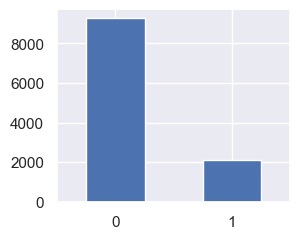

In [140]:
tweets_disaster_df = pd.read_csv(DATA_DIR / "nlp/tweets_disaster.csv")
vc = tweets_disaster_df["target"].value_counts()
print(vc)
tweets_disaster_df["target"].value_counts().plot.bar(rot=0, figsize=(3, 2.5));

In [141]:
tweets_disaster_train_df, tweets_disaster_test_df = train_test_split(tweets_disaster_df, test_size=0.2, random_state=0)

tweets_disaster_train_dataset = TweetsDisasterDataset(tweets_disaster_train_df)
tweets_disaster_test_dataset = TweetsDisasterDataset(
    tweets_disaster_test_df,
    vocab=tweets_disaster_train_dataset.vocab,
    encoder=tweets_disaster_train_dataset.encoder,
)
print(len(tweets_disaster_train_dataset.vocab), tweets_disaster_train_dataset.vocab.max_len)
len(tweets_disaster_train_dataset), len(tweets_disaster_test_dataset), tweets_disaster_train_dataset.classes

 97%|█████████▋| 2200/2274 [00:00<00:00, 2906.07it/s]


12490 21


(9096, 2274, ['0', '1'])